In [1]:
import array
from array import array
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from math import sqrt
import os

In [2]:
##set up the correct directory name with data
pathIn = "CalScale"

##Source 1 -> Co -> energy for gamma is 1.33 MeV and 1.17 MeV
fileName1 = "spectrometr_BGO_Co_53,98V_40dB_histo.txt"
##Source 2 -> Cs137 -> energy for gamma is 662 keV <- set up the correct file name with data
fileName2 = "spectrometr_BGO_137Cs_53,98V_40dB_histo.txt"

listFiles = [fileName1,fileName2]
listPhotoPeaks = [2,1]

##set up left X axis limit on histogram for analysis
Xleft = 333500.0  
Xright = 340000.0  

pathOut = 'results'
if not os.path.exists(pathOut):
    os.mkdir(pathOut)
outSpectr = 'spectr_BGO_2sources.png'
outCalADCScale = 'EnergyCalibration_BGO_2sources.png'
outEnRes = 'EnergyResolution_BGO_2sources.png'
outPhotopeakCompton = 'RatioPhotopeakToCompton_BGO_2sources.png'

energy, ADCcharray, enRes, ratioPhotopeakToCompton  = np.array([]),np.array([]),np.array([]),np.array([])

energy = np.append(energy, 1.330)
energy = np.append(energy, 1.170)
energy = np.append(energy, 0.662)  

In [3]:
##determine functions for fit the data
def Gauss(x, a, x0, s):
    return a*np.exp(-((x-x0)/s)**2)

def DoubleGauss(x, a1, x01, s1, a2, x02, s2):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2)

def nGauss(x, *p):
    n = len(p)/3
    res = 0
    for i in range(n):
        res += Gauss(x, p[i*3], p[i*3+1], p[i*3+2])
    return res

def plotAllGauss(x, p):
    n = len(p)//3
    for i in range(n):
        plt.plot(x, Gauss(x,p[i*3],p[i*3+1],p[i*3+2]), 'b', linewidth=0.5)
        
def fitline(x, A, B): 
    return A*x + B

i_peaks= [2412 2470 2554 2782 2842]  x[i_peaks]= [334124.902 334704.912 335544.926 337824.964 338424.974]  y[i_peaks]= [143. 179. 123. 272. 953.]
len(i_peaks)= 5  x_lastPeak= 338424.974
index= 0
npeaks =  2
n= 0  peak= 334124.902
0 peak: Параметры гауссианов:  [2.55259715e+01 3.34124902e+05 4.49397186e+03 9.40459740e+01
 3.34124902e+05 1.89014777e+02]
Стандартное отклонение:  21.969031761257664
Квадрат коэффициента корреляции:  0.5682881755321402
comptonPeak= 335544.926
n= 1  peak= 334704.912
1 peak: Параметры гауссианов:  [6.64761753e+01 3.34704912e+05 1.25840206e+03 9.98085804e+01
 3.34682514e+05 1.74904167e+02]
Стандартное отклонение:  10.382560365219202
Квадрат коэффициента корреляции:  0.9217303159696018
comptonPeak= 335544.926


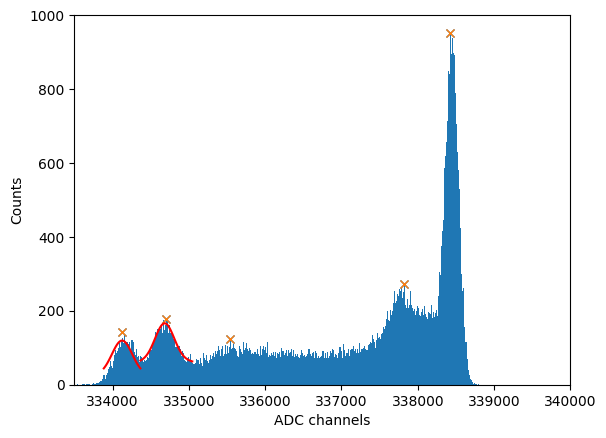

i_peaks= [2631 2687 2786 2843]  x[i_peaks]= [336314.939 336874.948 337864.964 338434.974]  y[i_peaks]= [1691.  548. 1262. 4931.]
len(i_peaks)= 4  x_lastPeak= 338434.974
index= 1
npeaks =  1
n= 0  peak= 336314.939
0 peak: Параметры гауссианов:  [6.68816613e+02 3.36303127e+05 1.08975042e+02 1.00000000e+03
 3.36314939e+05 2.14636346e+02]
Стандартное отклонение:  53.995841009918294
Квадрат коэффициента корреляции:  0.9866151320982021
comptonPeak= 336874.948


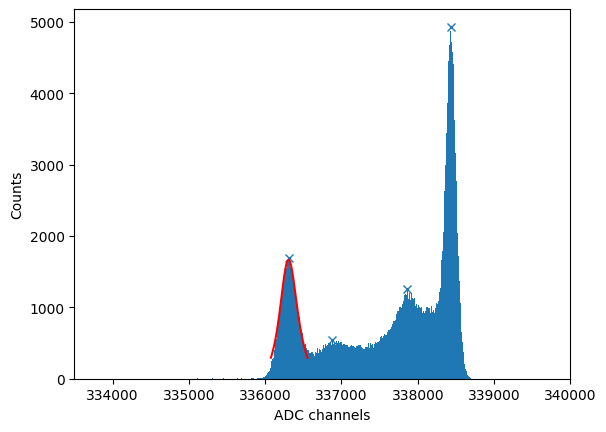

y =  -3243.707717503595 *x +  338455.7154052156


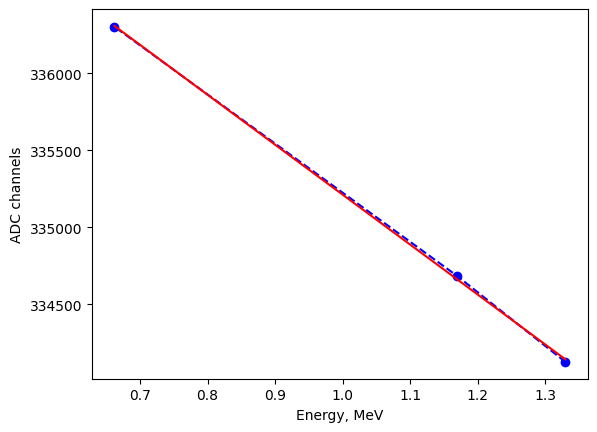

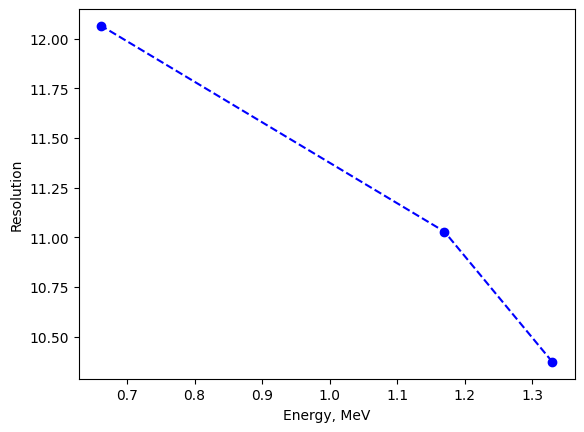

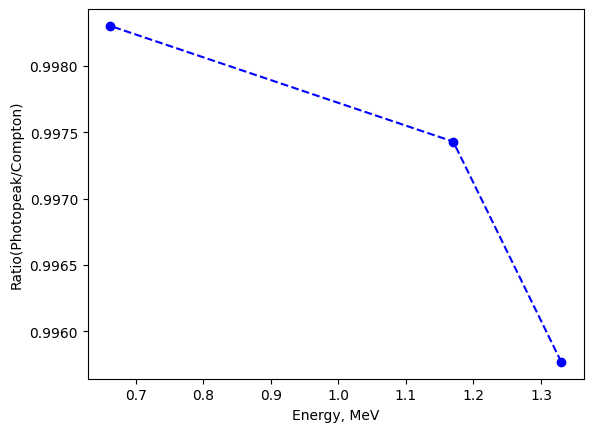

In [4]:
for fileName in listFiles:    
    x,y = np.array([]), np.array([])
    
    file1 = open(pathIn + "/" + fileName)
    for line1 in file1.readlines():
        line1 = line1.replace(',','.')
        b = line1.split()
        b[0] = float(b[0])
        b[1] = float(b[1])
        x = np.append(x, b[0])
        y = np.append(y, b[1])
    
    #plt.plot(x, y,'o',markersize=4)  
    plt.bar(x, y, width=10.0)
    plt.xlabel('ADC channels')
    plt.ylabel('Counts')
    plt.xlim([Xleft, Xright])
    #plt.yscale('log')

    #Find peaks
    #thresh_top    = np.median(y) + 1.5 * np.std(y)
    thresh_top    = np.median(y) + 1.4 * np.std(y)
    i_peaks, _ = find_peaks(y,  height=thresh_top, width=1, distance=50)
    print('i_peaks=',i_peaks,' x[i_peaks]=',x[i_peaks],' y[i_peaks]=',y[i_peaks])
    print('len(i_peaks)=',len(i_peaks),' x_lastPeak=',x[i_peaks][len(i_peaks)-1])
    
    ##Fit peaks
    index = listFiles.index(fileName)
    npeaks = listPhotoPeaks[index]
    print('index=',index)
    print('npeaks = ',npeaks)
    
    for n in range(npeaks):
        peak = x[i_peaks][n]
        print('n=',n,' peak=',peak)    
    
        #plt.plot([min(y), max(y)], [thresh_top, thresh_top],'--',  color='r', label='peaks-threshold') # Plot threshold
        plt.plot(x[i_peaks], y[i_peaks], 'x')
    
        board1 = peak-350.
        board2 = peak+350.
        if n==0:
            board1 = peak-250.
            board2 = peak+250.
        mask = (x>board1) & (x<board2)
        x1 = x[mask]
        y1 = y[mask]

        init_valsp = [.025, peak-300, 30., .025, peak-300, 30.]
        p, cov = curve_fit(DoubleGauss, x1, y1, p0=init_valsp, bounds=(0, [1000., peak, 100000., 1000., peak, 100000.]))
        fit_y = DoubleGauss(x1, *p)    
        print(n, "peak: Параметры гауссианов: ",p)
        #оценка погрешности аппроксимации и достоверности модели
        print("Стандартное отклонение: ", np.std(y1-fit_y))
        slope, ic, r_value, p_value, std_err = stats.linregress(y1,fit_y)
        print("Квадрат коэффициента корреляции: ", r_value**2)

        plt.plot(x1, fit_y, 'r')

        sigma = p[5]
        mean = p[4]
        if p[2]<p[5]:
            sigma = p[2]        
            mean = p[1]
            
        ADCcharray = np.append(ADCcharray, mean)        
        enRes = np.append(enRes, 2.36*sigma*100/(x[i_peaks][len(i_peaks)-1]-mean))
        ratioPhotopeakToCompton = np.append(ratioPhotopeakToCompton, mean/x[i_peaks][npeaks])
        print('comptonPeak=',x[i_peaks][npeaks])

    plt.savefig(pathOut + '/' + str(index) + outSpectr)    
    plt.show() 
    
plt.plot(energy, ADCcharray,'ob--')
popt, pcov = curve_fit(fitline, energy, ADCcharray)
print('y = ',popt[0],'*x + ',popt[1])
fit_l = fitline(energy, *popt)
plt.plot(energy, fit_l, 'r')
plt.xlabel('Energy, MeV')
plt.ylabel('ADC channels')
plt.savefig(pathOut + '/' + outCalADCScale)
plt.show()

plt.plot(energy, enRes,'ob--')
plt.xlabel('Energy, MeV')
plt.ylabel('Resolution')
plt.savefig(pathOut + '/' + outEnRes)
plt.show()

plt.plot(energy, ratioPhotopeakToCompton,'ob--')
plt.xlabel('Energy, MeV')
plt.ylabel('Ratio(Photopeak/Compton)')
plt.savefig(pathOut + '/' + outPhotopeakCompton)
plt.show()
